The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


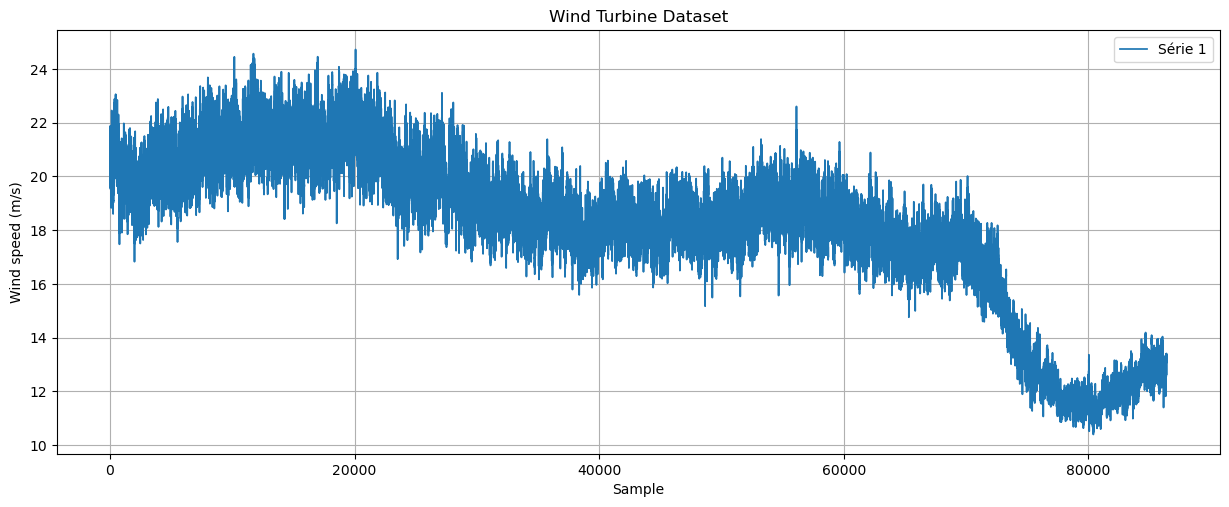

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
from scipy.linalg import expm

import math
from _GraphUtils import *

params = {
    
    'ALPHA' : 0.1,
    'ALPHA_gc' : 50,
    'Area' :  math.pi * (57.5**2),
    'B_dt' : 755.49,
    'B_r' : 7.11,
    'B_g' : 45.6,
    'Cp_max' : 0.486,
    'D_max' : 1000,
    'ETA_dt' : 0.97,
    'ETA_gc' : 0.98,
    'f_s': 0.01,
    'H' : 81,
    'J_r' : 55*1e6,
    'J_g' : 390,
    'K_dt' : 2.7*1e9,
    'K_opt' : 1.2171,
    'k_i' : 1,
    'k_p' : 4,
    'LAMBDA_opt' : 7.6,
    'N_g' : 95,
    'OMEGA_n' : 11.11,
    'OMEGA_nom' : 162,
    'OMEGA_var' : 15,
    'PI' : np.pi,
    'PHI_opt' : 0,
    'P_r' : 4.8*1e6,
    'r_0' : 1.5,
    'R' : 57.5,
    'RHO' : 1.225,
    'T_s' : 1,
    'ZETA' : 0.6,

}

def Cp_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

def Cq_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'Cq.csv'
    df = pd.read_csv(path)
    angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

path = r'WindSpeedML.csv'
df = pd.read_csv(path)  
v = df.iloc[:,1].values 

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5

PlotSeries(y_arrays=[v[:]],w=15,h=5.5,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [10]:


class HAWT:
    def __init__(self, **params):

        self.Area =params['Area']
        self.ALPHA_gc = params['ALPHA_gc']
        self.B_dt =params['B_dt']
        self.B_r =params['B_r']
        self.B_g =params['B_g']
        self.Cp_max =params['Cp_max']
        self.ETA_dt =params['ETA_dt']
        self.ETA_gc =params['ETA_gc']
        self.f_s =params['f_s']
        self.J_r =params['J_r']
        self.J_g =params['J_g']
        self.K_dt =params['K_dt']
        self.K_opt =params['K_opt']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.LAMBDA_opt =params['LAMBDA_opt']
        self.N_g =params['N_g']
        self.OMEGA_n =params['OMEGA_n']
        self.OMEGA_nom =params['OMEGA_nom']
        self.OMEGA_var =params['OMEGA_var']
        self.PHI_opt = params['PHI_opt']
        self.P_r =params['P_r']
        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        self.T_s = params['T_s']
        self.ZETA = params['ZETA']
        
        self.X  = np.array([0,0,0,0])
        self.X_ptich  = np.zeros((2, 1))
        self.dX = np.array([0,0,0,0,0]) 
        self.dX_ptich  = np.zeros((2, 1))
        self.e = np.array([0])
        self.PHI_ref = np.array([0])   
        self.PHI_m = np.array([0])   
        self.P_g = np.array([])  
        self.P_d = np.array([]) 
        self.OMEGA_g = np.array([])  
        self.mode = np.array([])     
        self.ctrl_mode = 'mode1'
        self.U = None

        #PitchController
        num = [self.OMEGA_n**2]
        den = [1, 2*self.ZETA*self.OMEGA_n, self.OMEGA_n**2]
        A, B, C, D = tf2ss(num, den)
        self.PitchController = cont2discrete((A, B, C, D), self.T_s, method='bilinear')
        
        #GeneratorConverterModel
        num = [self.ALPHA_gc]
        den = [1, self.ALPHA_gc]
        A, B, C, D = tf2ss(num, den)
        self.TorqueController = cont2discrete((A, B, C, D), self.T_s, method='bilinear')
        

    def set_state(self, X):
        self.X = X.flatten()

    def Calculate_TAU_r(self, OMEGA_r, v, PHI=0):
        
        LAMBDA = OMEGA_r*self.R/v
        C_q = Cq_calc(LAMBDA, PHI)
        TAU = self.RHO*self.PI*(self.R**3)*C_q*(v**2)/(2)
        return TAU

    def Calculate_TAU_gr(self, OMEGA_g, u_k=0, PHI=0):
        
        LAMBDA = self.LAMBDA_opt+u_k
        C_p = Cp_calc(LAMBDA,PHI)
        K_mppt = 0.5*self.RHO*self.Area*(self.R**3)*C_p/(LAMBDA**3)
        TAU_gr = K_mppt*(OMEGA_g**2)/(self.N_g**2)
        P_g = self.ETA_gc*OMEGA_g*TAU_gr

        if P_g >= self.P_r or OMEGA_g >= self.OMEGA_nom:
            self.ctrl_mode = 'mode2'
        if OMEGA_g < self.OMEGA_nom - self.OMEGA_var:
            self.ctrl_mode = 'mode1'

        if self.ctrl_mode == 'mode1':
            self.mode = np.append(self.mode,1)
            self.K_mppt = K_mppt
            self.TAU_gr = TAU_gr
            self.PHI_ref = np.append(self.PHI_ref, 0)
            self.PHI_m = np.append(self.PHI_m, 0)

        if self.ctrl_mode == 'mode2':
            self.mode = np.append(self.mode,2)
            TAU_gr = self.P_r/(self.ETA_gc*OMEGA_g)
            e = OMEGA_g - self.OMEGA_nom
            PHI_ref = self.PHI_ref[-1] + self.k_p*e + (self.k_i*self.T_s - self.k_p)*self.e[-1]
            self.e = np.append(self.e, e)
            self.PHI_ref = np.append(self.PHI_ref, PHI_ref)

        return TAU_gr, self.PHI_ref[-1]

    def dynamics(self, t, X, U):

        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        A54 = -(self.OMEGA_n**2)
        A55 = -(2*self.ZETA*self.OMEGA_n)
        
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        B53 = (self.OMEGA_n**2)
        
        A = np.array([[A11, A12, A13,   0,   0],
                      [A21, A22, A23,   0,   0],
                      [  1, A32,   0,   0,   0],
                      [  0,   0,   0,   0,   1],
                      [  0,   0,   0, A54, A55]])
        
        B = np.array([[B11,   0,   0],
                      [  0, B22,   0],
                      [  0,   0,   0],
                      [  0,   0,   0],
                      [  0,   0, B53]])
        
        Ad = expm(A * self.T_s)
        Bd = np.linalg.inv(A).dot((Ad - np.eye(A.shape[0]))).dot(B)

        dX = (Ad@X.reshape(-1,1))+(Bd@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, X, v, u_k=0):
        
        OMEGA_r, OMEGA_g = X[0], X[1]
        TAU_r = self.Calculate_TAU_r(OMEGA_r, v, PHI=self.PHI_m[-1])
        TAU_g, PHI_ref = self.Calculate_TAU_gr(OMEGA_g, u_k, PHI=self.PHI_ref[-1])
        du = np.array([TAU_r,TAU_g,PHI_ref])
        self.U = du
        
        return du
    
    def iterate(self, u, dt):
        #DOP853
        sol = solve_ivp(self.dynamics, [0, dt], self.X, 
            args=(u.flatten(),), method="RK23", t_eval=[dt])
        self.X = sol.y[:, -1]
        return self.X
    
    def iterate2(self, U):
        dt=self.T_s
        self.X = self.dynamics(dt,self.X,U)
        
        return self.X
    
    def compute_output(self):
        X = self.X.reshape(1,-1)
        dX = self.dX.reshape(1,-1)
        TAU_r, TAU_g, PHI_ref = self.U
        OMEGA_r, OMEGA_g,THETA, PHI_m, dPHI_m = self.X

        P_g = TAU_g*OMEGA_g*self.ETA_gc
        P_d = self.B_dt*((OMEGA_r-OMEGA_g)**2)
        self.P_g = np.append(self.P_g,P_g)
        self.P_d = np.append(self.P_d,P_d)
        self.OMEGA_g = np.append(self.OMEGA_g,OMEGA_g)
        self.PHI_m = np.append(self.PHI_m, PHI_m)



In [12]:
hawt = HAWT(**params)
X=np.array([1,1,1,1,1])

hawt.set_state(X)

e = 100000
for i,v_ in enumerate(v[:]):
    print(i,'/',len(v))
    #if i%5==0: clear_output(wait=False)
    U = hawt.compute_input(X,v=v_,u_k=0)
    X = hawt.iterate2(U)
    print(X)
    #hawt.compute_output()

0 / 86400
[ 7.33801873e-01  4.38591524e+02 -9.36387972e-01 -5.32695980e-04
 -1.06266201e-02]
1 / 86400
[ 1.39289833e+00 -4.77572270e+02  8.67329047e-01  1.10703651e+03
  1.00058017e+01]
2 / 86400
[-4.21088804e+01 -3.42761512e+03  9.00801599e-01 -6.70092932e-01
 -1.00276804e+01]
3 / 86400
[-2.93517262e+03 -2.95708789e+05  1.13959733e+02 -3.28671126e-04
  2.19319775e-02]
4 / 86400
[-2.15423992e+07 -2.16990532e+09  8.54648397e+05  1.80611120e-06
 -3.17414084e-05]
5 / 86400
[-1.15981188e+15 -1.16828084e+17  4.60251411e+13 -3.42012240e-09
  3.39060311e-08]
6 / 86400
[-3.36202147e+30 -3.38657102e+32  1.33416049e+29  4.55675878e-12
 -2.27353549e-11]
7 / 86400
[-2.82505137e+61 -2.84567995e+63  1.12107313e+60 -4.42705006e-15
 -5.22508892e-15]
8 / 86400
[-1.99470227e+123 -2.00926762e+125  7.91563343e+121  2.29979976e-018
  4.83077121e-017]
9 / 86400
[-9.94446778e+246 -1.00170825e+249  3.94629128e+245  2.14588846e-021
 -9.72602503e-020]
10 / 86400
[-inf -inf  inf  nan  nan]
11 / 86400
[nan nan na

C:\Users\claud\AppData\Local\Temp\ipykernel_24216\3246717782.py:75: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\claud\AppData\Local\Temp\ipykernel_24216\3246717782.py:74: RuntimeWarning:

overflow encountered in scalar power

C:\Users\claud\AppData\Local\Temp\ipykernel_24216\3246717782.py:130: RuntimeWarning:

invalid value encountered in matmul

C:\Users\claud\AppData\Local\Temp\ipykernel_24216\3246717782.py:130: RuntimeWarning:

invalid value encountered in matmul

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packa

[nan nan nan nan nan]
78 / 86400
[nan nan nan nan nan]
79 / 86400
[nan nan nan nan nan]
80 / 86400
[nan nan nan nan nan]
81 / 86400
[nan nan nan nan nan]
82 / 86400
[nan nan nan nan nan]
83 / 86400
[nan nan nan nan nan]
84 / 86400
[nan nan nan nan nan]
85 / 86400
[nan nan nan nan nan]
86 / 86400
[nan nan nan nan nan]
87 / 86400
[nan nan nan nan nan]
88 / 86400
[nan nan nan nan nan]
89 / 86400
[nan nan nan nan nan]
90 / 86400
[nan nan nan nan nan]
91 / 86400
[nan nan nan nan nan]
92 / 86400
[nan nan nan nan nan]
93 / 86400
[nan nan nan nan nan]
94 / 86400
[nan nan nan nan nan]
95 / 86400
[nan nan nan nan nan]
96 / 86400
[nan nan nan nan nan]
97 / 86400
[nan nan nan nan nan]
98 / 86400
[nan nan nan nan nan]
99 / 86400
[nan nan nan nan nan]
100 / 86400
[nan nan nan nan nan]
101 / 86400
[nan nan nan nan nan]
102 / 86400
[nan nan nan nan nan]
103 / 86400
[nan nan nan nan nan]
104 / 86400
[nan nan nan nan nan]
105 / 86400
[nan nan nan nan nan]
106 / 86400
[nan nan nan nan nan]
107 / 86400
[n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
157 / 86400
[nan nan nan nan nan]
158 / 86400
[nan nan nan nan nan]
159 / 86400
[nan nan nan nan nan]
160 / 86400
[nan nan nan nan nan]
161 / 86400
[nan nan nan nan nan]
162 / 86400
[nan nan nan nan nan]
163 / 86400
[nan nan nan nan nan]
164 / 86400
[nan nan nan nan nan]
165 / 86400
[nan nan nan nan nan]
166 / 86400
[nan nan nan nan nan]
167 / 86400
[nan nan nan nan nan]
168 / 86400
[nan nan nan nan nan]
169 / 86400
[nan nan nan nan nan]
170 / 86400
[nan nan nan nan nan]
171 / 86400
[nan nan nan nan nan]
172 / 86400
[nan nan nan nan nan]
173 / 86400
[nan nan nan nan nan]
174 / 86400
[nan nan nan nan nan]
175 / 86400
[nan nan nan nan nan]
176 / 86400
[nan nan nan nan nan]
177 / 86400
[nan nan nan nan nan]
178 / 86400
[nan nan nan nan nan]
179 / 86400
[nan nan nan nan nan]
180 / 86400
[nan nan nan nan nan]
181 / 86400
[nan nan nan nan nan]
182 / 86400
[nan nan nan nan nan]
183 / 86400
[nan nan nan nan nan]
184 / 86400
[nan nan nan nan nan]
185 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
344 / 86400
[nan nan nan nan nan]
345 / 86400
[nan nan nan nan nan]
346 / 86400
[nan nan nan nan nan]
347 / 86400
[nan nan nan nan nan]
348 / 86400
[nan nan nan nan nan]
349 / 86400
[nan nan nan nan nan]
350 / 86400
[nan nan nan nan nan]
351 / 86400
[nan nan nan nan nan]
352 / 86400
[nan nan nan nan nan]
353 / 86400
[nan nan nan nan nan]
354 / 86400
[nan nan nan nan nan]
355 / 86400
[nan nan nan nan nan]
356 / 86400
[nan nan nan nan nan]
357 / 86400
[nan nan nan nan nan]
358 / 86400
[nan nan nan nan nan]
359 / 86400
[nan nan nan nan nan]
360 / 86400
[nan nan nan nan nan]
361 / 86400
[nan nan nan nan nan]
362 / 86400
[nan nan nan nan nan]
363 / 86400
[nan nan nan nan nan]
364 / 86400
[nan nan nan nan nan]
365 / 86400
[nan nan nan nan nan]
366 / 86400
[nan nan nan nan nan]
367 / 86400
[nan nan nan nan nan]
368 / 86400
[nan nan nan nan nan]
369 / 86400
[nan nan nan nan nan]
370 / 86400
[nan nan nan nan nan]
371 / 86400
[nan nan nan nan nan]
372 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
437 / 86400
[nan nan nan nan nan]
438 / 86400
[nan nan nan nan nan]
439 / 86400
[nan nan nan nan nan]
440 / 86400
[nan nan nan nan nan]
441 / 86400
[nan nan nan nan nan]
442 / 86400
[nan nan nan nan nan]
443 / 86400
[nan nan nan nan nan]
444 / 86400
[nan nan nan nan nan]
445 / 86400
[nan nan nan nan nan]
446 / 86400
[nan nan nan nan nan]
447 / 86400
[nan nan nan nan nan]
448 / 86400
[nan nan nan nan nan]
449 / 86400
[nan nan nan nan nan]
450 / 86400
[nan nan nan nan nan]
451 / 86400
[nan nan nan nan nan]
452 / 86400
[nan nan nan nan nan]
453 / 86400
[nan nan nan nan nan]
454 / 86400
[nan nan nan nan nan]
455 / 86400
[nan nan nan nan nan]
456 / 86400
[nan nan nan nan nan]
457 / 86400
[nan nan nan nan nan]
458 / 86400
[nan nan nan nan nan]
459 / 86400
[nan nan nan nan nan]
460 / 86400
[nan nan nan nan nan]
461 / 86400
[nan nan nan nan nan]
462 / 86400
[nan nan nan nan nan]
463 / 86400
[nan nan nan nan nan]
464 / 86400
[nan nan nan nan nan]
465 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
631 / 86400
[nan nan nan nan nan]
632 / 86400
[nan nan nan nan nan]
633 / 86400
[nan nan nan nan nan]
634 / 86400
[nan nan nan nan nan]
635 / 86400
[nan nan nan nan nan]
636 / 86400
[nan nan nan nan nan]
637 / 86400
[nan nan nan nan nan]
638 / 86400
[nan nan nan nan nan]
639 / 86400
[nan nan nan nan nan]
640 / 86400
[nan nan nan nan nan]
641 / 86400
[nan nan nan nan nan]
642 / 86400
[nan nan nan nan nan]
643 / 86400
[nan nan nan nan nan]
644 / 86400
[nan nan nan nan nan]
645 / 86400
[nan nan nan nan nan]
646 / 86400
[nan nan nan nan nan]
647 / 86400
[nan nan nan nan nan]
648 / 86400
[nan nan nan nan nan]
649 / 86400
[nan nan nan nan nan]
650 / 86400
[nan nan nan nan nan]
651 / 86400
[nan nan nan nan nan]
652 / 86400
[nan nan nan nan nan]
653 / 86400
[nan nan nan nan nan]
654 / 86400
[nan nan nan nan nan]
655 / 86400
[nan nan nan nan nan]
656 / 86400
[nan nan nan nan nan]
657 / 86400
[nan nan nan nan nan]
658 / 86400
[nan nan nan nan nan]
659 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
729 / 86400
[nan nan nan nan nan]
730 / 86400
[nan nan nan nan nan]
731 / 86400
[nan nan nan nan nan]
732 / 86400
[nan nan nan nan nan]
733 / 86400
[nan nan nan nan nan]
734 / 86400
[nan nan nan nan nan]
735 / 86400
[nan nan nan nan nan]
736 / 86400
[nan nan nan nan nan]
737 / 86400
[nan nan nan nan nan]
738 / 86400
[nan nan nan nan nan]
739 / 86400
[nan nan nan nan nan]
740 / 86400
[nan nan nan nan nan]
741 / 86400
[nan nan nan nan nan]
742 / 86400
[nan nan nan nan nan]
743 / 86400
[nan nan nan nan nan]
744 / 86400
[nan nan nan nan nan]
745 / 86400
[nan nan nan nan nan]
746 / 86400
[nan nan nan nan nan]
747 / 86400
[nan nan nan nan nan]
748 / 86400
[nan nan nan nan nan]
749 / 86400
[nan nan nan nan nan]
750 / 86400
[nan nan nan nan nan]
751 / 86400
[nan nan nan nan nan]
752 / 86400
[nan nan nan nan nan]
753 / 86400
[nan nan nan nan nan]
754 / 86400
[nan nan nan nan nan]
755 / 86400
[nan nan nan nan nan]
756 / 86400
[nan nan nan nan nan]
757 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
817 / 86400
[nan nan nan nan nan]
818 / 86400
[nan nan nan nan nan]
819 / 86400
[nan nan nan nan nan]
820 / 86400
[nan nan nan nan nan]
821 / 86400
[nan nan nan nan nan]
822 / 86400
[nan nan nan nan nan]
823 / 86400
[nan nan nan nan nan]
824 / 86400
[nan nan nan nan nan]
825 / 86400
[nan nan nan nan nan]
826 / 86400
[nan nan nan nan nan]
827 / 86400
[nan nan nan nan nan]
828 / 86400
[nan nan nan nan nan]
829 / 86400
[nan nan nan nan nan]
830 / 86400
[nan nan nan nan nan]
831 / 86400
[nan nan nan nan nan]
832 / 86400
[nan nan nan nan nan]
833 / 86400
[nan nan nan nan nan]
834 / 86400
[nan nan nan nan nan]
835 / 86400
[nan nan nan nan nan]
836 / 86400
[nan nan nan nan nan]
837 / 86400
[nan nan nan nan nan]
838 / 86400
[nan nan nan nan nan]
839 / 86400
[nan nan nan nan nan]
840 / 86400
[nan nan nan nan nan]
841 / 86400
[nan nan nan nan nan]
842 / 86400
[nan nan nan nan nan]
843 / 86400
[nan nan nan nan nan]
844 / 86400
[nan nan nan nan nan]
845 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
912 / 86400
[nan nan nan nan nan]
913 / 86400
[nan nan nan nan nan]
914 / 86400
[nan nan nan nan nan]
915 / 86400
[nan nan nan nan nan]
916 / 86400
[nan nan nan nan nan]
917 / 86400
[nan nan nan nan nan]
918 / 86400
[nan nan nan nan nan]
919 / 86400
[nan nan nan nan nan]
920 / 86400
[nan nan nan nan nan]
921 / 86400
[nan nan nan nan nan]
922 / 86400
[nan nan nan nan nan]
923 / 86400
[nan nan nan nan nan]
924 / 86400
[nan nan nan nan nan]
925 / 86400
[nan nan nan nan nan]
926 / 86400
[nan nan nan nan nan]
927 / 86400
[nan nan nan nan nan]
928 / 86400
[nan nan nan nan nan]
929 / 86400
[nan nan nan nan nan]
930 / 86400
[nan nan nan nan nan]
931 / 86400
[nan nan nan nan nan]
932 / 86400
[nan nan nan nan nan]
933 / 86400
[nan nan nan nan nan]
934 / 86400
[nan nan nan nan nan]
935 / 86400
[nan nan nan nan nan]
936 / 86400
[nan nan nan nan nan]
937 / 86400
[nan nan nan nan nan]
938 / 86400
[nan nan nan nan nan]
939 / 86400
[nan nan nan nan nan]
940 / 86400
[nan nan nan n

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1006 / 86400
[nan nan nan nan nan]
1007 / 86400
[nan nan nan nan nan]
1008 / 86400
[nan nan nan nan nan]
1009 / 86400
[nan nan nan nan nan]
1010 / 86400
[nan nan nan nan nan]
1011 / 86400
[nan nan nan nan nan]
1012 / 86400
[nan nan nan nan nan]
1013 / 86400
[nan nan nan nan nan]
1014 / 86400
[nan nan nan nan nan]
1015 / 86400
[nan nan nan nan nan]
1016 / 86400
[nan nan nan nan nan]
1017 / 86400
[nan nan nan nan nan]
1018 / 86400
[nan nan nan nan nan]
1019 / 86400
[nan nan nan nan nan]
1020 / 86400
[nan nan nan nan nan]
1021 / 86400
[nan nan nan nan nan]
1022 / 86400
[nan nan nan nan nan]
1023 / 86400
[nan nan nan nan nan]
1024 / 86400
[nan nan nan nan nan]
1025 / 86400
[nan nan nan nan nan]
1026 / 86400
[nan nan nan nan nan]
1027 / 86400
[nan nan nan nan nan]
1028 / 86400
[nan nan nan nan nan]
1029 / 86400
[nan nan nan nan nan]
1030 / 86400
[nan nan nan nan nan]
1031 / 86400
[nan nan nan nan nan]
1032 / 86400
[nan nan nan nan nan]
1033 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1093 / 86400
[nan nan nan nan nan]
1094 / 86400
[nan nan nan nan nan]
1095 / 86400
[nan nan nan nan nan]
1096 / 86400
[nan nan nan nan nan]
1097 / 86400
[nan nan nan nan nan]
1098 / 86400
[nan nan nan nan nan]
1099 / 86400
[nan nan nan nan nan]
1100 / 86400
[nan nan nan nan nan]
1101 / 86400
[nan nan nan nan nan]
1102 / 86400
[nan nan nan nan nan]
1103 / 86400
[nan nan nan nan nan]
1104 / 86400
[nan nan nan nan nan]
1105 / 86400
[nan nan nan nan nan]
1106 / 86400
[nan nan nan nan nan]
1107 / 86400
[nan nan nan nan nan]
1108 / 86400
[nan nan nan nan nan]
1109 / 86400
[nan nan nan nan nan]
1110 / 86400
[nan nan nan nan nan]
1111 / 86400
[nan nan nan nan nan]
1112 / 86400
[nan nan nan nan nan]
1113 / 86400
[nan nan nan nan nan]
1114 / 86400
[nan nan nan nan nan]
1115 / 86400
[nan nan nan nan nan]
1116 / 86400
[nan nan nan nan nan]
1117 / 86400
[nan nan nan nan nan]
1118 / 86400
[nan nan nan nan nan]
1119 / 86400
[nan nan nan nan nan]
1120 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1271 / 86400
[nan nan nan nan nan]
1272 / 86400
[nan nan nan nan nan]
1273 / 86400
[nan nan nan nan nan]
1274 / 86400
[nan nan nan nan nan]
1275 / 86400
[nan nan nan nan nan]
1276 / 86400
[nan nan nan nan nan]
1277 / 86400
[nan nan nan nan nan]
1278 / 86400
[nan nan nan nan nan]
1279 / 86400
[nan nan nan nan nan]
1280 / 86400
[nan nan nan nan nan]
1281 / 86400
[nan nan nan nan nan]
1282 / 86400
[nan nan nan nan nan]
1283 / 86400
[nan nan nan nan nan]
1284 / 86400
[nan nan nan nan nan]
1285 / 86400
[nan nan nan nan nan]
1286 / 86400
[nan nan nan nan nan]
1287 / 86400
[nan nan nan nan nan]
1288 / 86400
[nan nan nan nan nan]
1289 / 86400
[nan nan nan nan nan]
1290 / 86400
[nan nan nan nan nan]
1291 / 86400
[nan nan nan nan nan]
1292 / 86400
[nan nan nan nan nan]
1293 / 86400
[nan nan nan nan nan]
1294 / 86400
[nan nan nan nan nan]
1295 / 86400
[nan nan nan nan nan]
1296 / 86400
[nan nan nan nan nan]
1297 / 86400
[nan nan nan nan nan]
1298 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1362 / 86400
[nan nan nan nan nan]
1363 / 86400
[nan nan nan nan nan]
1364 / 86400
[nan nan nan nan nan]
1365 / 86400
[nan nan nan nan nan]
1366 / 86400
[nan nan nan nan nan]
1367 / 86400
[nan nan nan nan nan]
1368 / 86400
[nan nan nan nan nan]
1369 / 86400
[nan nan nan nan nan]
1370 / 86400
[nan nan nan nan nan]
1371 / 86400
[nan nan nan nan nan]
1372 / 86400
[nan nan nan nan nan]
1373 / 86400
[nan nan nan nan nan]
1374 / 86400
[nan nan nan nan nan]
1375 / 86400
[nan nan nan nan nan]
1376 / 86400
[nan nan nan nan nan]
1377 / 86400
[nan nan nan nan nan]
1378 / 86400
[nan nan nan nan nan]
1379 / 86400
[nan nan nan nan nan]
1380 / 86400
[nan nan nan nan nan]
1381 / 86400
[nan nan nan nan nan]
1382 / 86400
[nan nan nan nan nan]
1383 / 86400
[nan nan nan nan nan]
1384 / 86400
[nan nan nan nan nan]
1385 / 86400
[nan nan nan nan nan]
1386 / 86400
[nan nan nan nan nan]
1387 / 86400
[nan nan nan nan nan]
1388 / 86400
[nan nan nan nan nan]
1389 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1531 / 86400
[nan nan nan nan nan]
1532 / 86400
[nan nan nan nan nan]
1533 / 86400
[nan nan nan nan nan]
1534 / 86400
[nan nan nan nan nan]
1535 / 86400
[nan nan nan nan nan]
1536 / 86400
[nan nan nan nan nan]
1537 / 86400
[nan nan nan nan nan]
1538 / 86400
[nan nan nan nan nan]
1539 / 86400
[nan nan nan nan nan]
1540 / 86400
[nan nan nan nan nan]
1541 / 86400
[nan nan nan nan nan]
1542 / 86400
[nan nan nan nan nan]
1543 / 86400
[nan nan nan nan nan]
1544 / 86400
[nan nan nan nan nan]
1545 / 86400
[nan nan nan nan nan]
1546 / 86400
[nan nan nan nan nan]
1547 / 86400
[nan nan nan nan nan]
1548 / 86400
[nan nan nan nan nan]
1549 / 86400
[nan nan nan nan nan]
1550 / 86400
[nan nan nan nan nan]
1551 / 86400
[nan nan nan nan nan]
1552 / 86400
[nan nan nan nan nan]
1553 / 86400
[nan nan nan nan nan]
1554 / 86400
[nan nan nan nan nan]
1555 / 86400
[nan nan nan nan nan]
1556 / 86400
[nan nan nan nan nan]
1557 / 86400
[nan nan nan nan nan]
1558 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1624 / 86400
[nan nan nan nan nan]
1625 / 86400
[nan nan nan nan nan]
1626 / 86400
[nan nan nan nan nan]
1627 / 86400
[nan nan nan nan nan]
1628 / 86400
[nan nan nan nan nan]
1629 / 86400
[nan nan nan nan nan]
1630 / 86400
[nan nan nan nan nan]
1631 / 86400
[nan nan nan nan nan]
1632 / 86400
[nan nan nan nan nan]
1633 / 86400
[nan nan nan nan nan]
1634 / 86400
[nan nan nan nan nan]
1635 / 86400
[nan nan nan nan nan]
1636 / 86400
[nan nan nan nan nan]
1637 / 86400
[nan nan nan nan nan]
1638 / 86400
[nan nan nan nan nan]
1639 / 86400
[nan nan nan nan nan]
1640 / 86400
[nan nan nan nan nan]
1641 / 86400
[nan nan nan nan nan]
1642 / 86400
[nan nan nan nan nan]
1643 / 86400
[nan nan nan nan nan]
1644 / 86400
[nan nan nan nan nan]
1645 / 86400
[nan nan nan nan nan]
1646 / 86400
[nan nan nan nan nan]
1647 / 86400
[nan nan nan nan nan]
1648 / 86400
[nan nan nan nan nan]
1649 / 86400
[nan nan nan nan nan]
1650 / 86400
[nan nan nan nan nan]
1651 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1798 / 86400
[nan nan nan nan nan]
1799 / 86400
[nan nan nan nan nan]
1800 / 86400
[nan nan nan nan nan]
1801 / 86400
[nan nan nan nan nan]
1802 / 86400
[nan nan nan nan nan]
1803 / 86400
[nan nan nan nan nan]
1804 / 86400
[nan nan nan nan nan]
1805 / 86400
[nan nan nan nan nan]
1806 / 86400
[nan nan nan nan nan]
1807 / 86400
[nan nan nan nan nan]
1808 / 86400
[nan nan nan nan nan]
1809 / 86400
[nan nan nan nan nan]
1810 / 86400
[nan nan nan nan nan]
1811 / 86400
[nan nan nan nan nan]
1812 / 86400
[nan nan nan nan nan]
1813 / 86400
[nan nan nan nan nan]
1814 / 86400
[nan nan nan nan nan]
1815 / 86400
[nan nan nan nan nan]
1816 / 86400
[nan nan nan nan nan]
1817 / 86400
[nan nan nan nan nan]
1818 / 86400
[nan nan nan nan nan]
1819 / 86400
[nan nan nan nan nan]
1820 / 86400
[nan nan nan nan nan]
1821 / 86400
[nan nan nan nan nan]
1822 / 86400
[nan nan nan nan nan]
1823 / 86400
[nan nan nan nan nan]
1824 / 86400
[nan nan nan nan nan]
1825 / 86400
[nan nan nan nan nan

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning:

The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.

c:\Users\claud\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py

[nan nan nan nan nan]
1893 / 86400
[nan nan nan nan nan]
1894 / 86400
[nan nan nan nan nan]
1895 / 86400
[nan nan nan nan nan]
1896 / 86400
[nan nan nan nan nan]
1897 / 86400
[nan nan nan nan nan]
1898 / 86400
[nan nan nan nan nan]
1899 / 86400
[nan nan nan nan nan]
1900 / 86400
[nan nan nan nan nan]
1901 / 86400
[nan nan nan nan nan]
1902 / 86400
[nan nan nan nan nan]
1903 / 86400
[nan nan nan nan nan]
1904 / 86400
[nan nan nan nan nan]
1905 / 86400
[nan nan nan nan nan]
1906 / 86400
[nan nan nan nan nan]
1907 / 86400
[nan nan nan nan nan]
1908 / 86400
[nan nan nan nan nan]
1909 / 86400
[nan nan nan nan nan]
1910 / 86400
[nan nan nan nan nan]
1911 / 86400
[nan nan nan nan nan]
1912 / 86400
[nan nan nan nan nan]
1913 / 86400
[nan nan nan nan nan]
1914 / 86400
[nan nan nan nan nan]
1915 / 86400
[nan nan nan nan nan]
1916 / 86400
[nan nan nan nan nan]
1917 / 86400
[nan nan nan nan nan]
1918 / 86400
[nan nan nan nan nan]
1919 / 86400
[nan nan nan nan nan]
1920 / 86400
[nan nan nan nan nan

KeyboardInterrupt: 

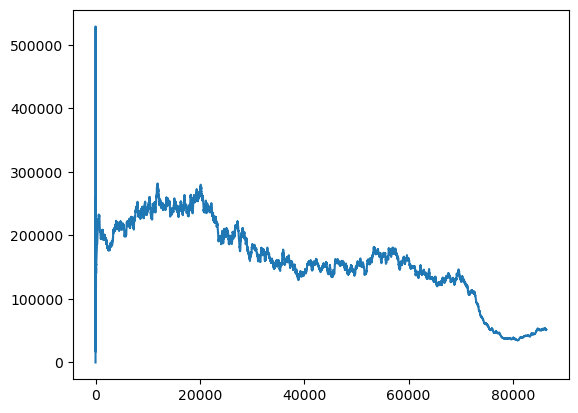

In [15]:
y = hawt.P_g[:]
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

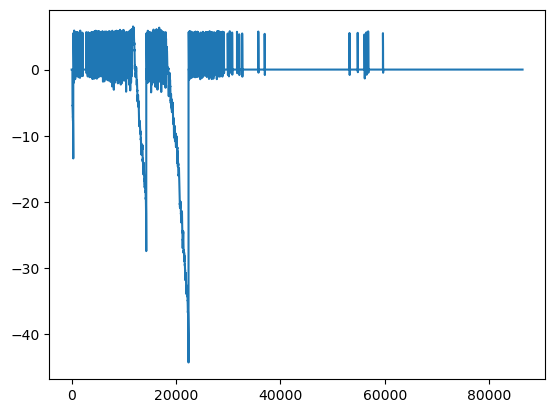

In [ ]:
y = hawt.PHI_m
x = np.arange(len(y))
y2 = np.array([hawt.P_r for i in range(len(x))])

plt.plot(x,y)

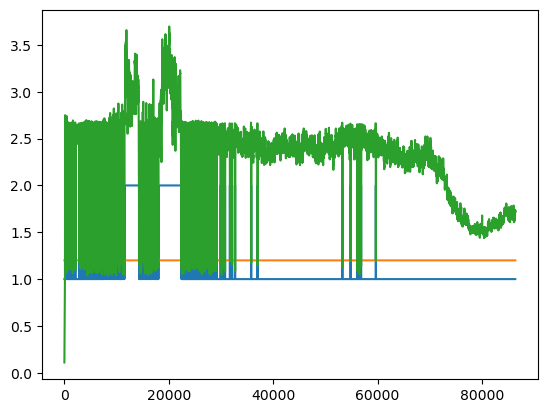

In [ ]:
y = hawt.OMEGA_g
x = np.arange(len(y))
y2 = np.array([hawt.OMEGA_nom-hawt.OMEGA_var for i in range(len(x))])
#y3 = np.array([hawt.mode for i in range(len(x))])
plt.plot(x,hawt.mode)
plt.plot(x,y2)
plt.plot(x,y)

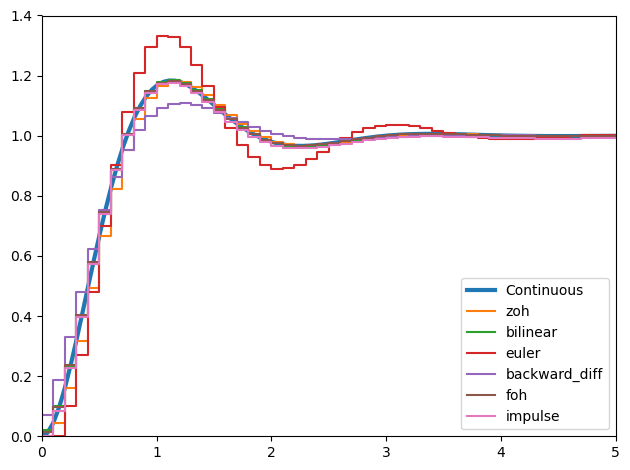

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lti, dlti, dstep

A = np.array([[0, 1],[-10., -3]])
B = np.array([[0],[10.]])
C = np.array([[1., 0]])
D = np.array([[0.]])
l_system = lti(A, B, C, D)
t, x = l_system.step(T=np.linspace(0, 5, 100))
fig, ax = plt.subplots()
ax.plot(t, x, label='Continuous', linewidth=3)

dt = 0.1
for method in ['zoh', 'bilinear', 'euler', 'backward_diff', 'foh', 'impulse']:
   d_system = cont2discrete((A, B, C, D), dt, method=method)
   s, x_d = dstep(d_system)
   ax.step(s, np.squeeze(x_d), label=method, where='post')
ax.axis([t[0], t[-1], x[0], 1.4])
ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [3]:
d_system

(array([[ 0.95501541,  0.08496335],
        [-0.8496335 ,  0.70012536]]),
 array([[0.08496335],
        [0.70012536]]),
 array([[1., 0.]]),
 array([[0.]]),
 0.1)